# <center> Simulator </center>

Code from internship 2018.

In [52]:
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter

## 0. Setting parameters

In [53]:
N = 10 # nb users
lambdas = np.random.random(N)
mus = np.random.random(N)
nb_tirages = 10000

## 1. Timestamps creation
Creates list with lines (user, time, activity_type).

In [54]:
# timestamps list
timestamps = []

# generate events user by user
for j in range(N):
    
    # generate selfposts
    time = 0
    for n in range(nb_tirages):
        dice = random.expovariate(lambdas[j])
        time += dice
        timestamps.append((j, time, 'post'))
        
    # generate reposts
    time = 0
    for n in range(nb_tirages):
        dice = random.expovariate(mus[j])
        time += dice
        timestamps.append((j, time, 'repost'))

# we only keep the nb_tirages first events
timestamps = sorted(timestamps, key=itemgetter(1))[:nb_tirages]

## 2. Trace generation
Creates trace (twid, uid, ts, rtid) from events list and user graph.

Parameters.

In [55]:
G = nx.gnp_random_graph(N, 2*np.log(N)/N, directed=True)
M = 10
K = 5
print("nb edges : ", G.number_of_edges())
print("strong connectivity : ", nx.is_strongly_connected(G))

nb edges :  40
strong connectivity :  True


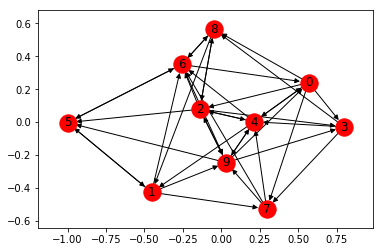

In [56]:
nx.draw_networkx(G)

In [57]:
mus

array([0.77345044, 0.08983724, 0.93156357, 0.61454056, 0.86617125,
       0.90733349, 0.93853717, 0.13569947, 0.46527574, 0.03328826])

Write graph on file.

In [58]:
graph_out = open("../Datasets/leadgraph_test.txt", "w")
for n in G.nodes:
    graph_out.write(str(n))
    for p in G.predecessors(n):
        graph_out.write(" " + str(p))
    graph_out.write("\n")
graph_out.close()

Out file path for writing trace.

In [59]:
out = open("../Datasets/trace_test.txt", "w")

Initialization.

In [60]:
# nb_posts_wall[i][j] : nb de posts de j dans wall de i
# nb_posts_news[i][j] : nb de posts de j dans newsfeed de i
nb_posts_wall = np.zeros(shape=(N,N))
nb_posts_news = np.zeros(shape=(N,N))

# leaders list creation from user graph
leaders = []
for i in range(N):
    leaders.append(list(G.predecessors(i)))

# on crée les wall et les newsfeed que l'on remplit aléatoirement uniformément
# avec de posts de n'impore qui
# on update en même temps nb_posts_wall et nb_posts_news
# les posts sont sous la forme [post id, original user id, nb reposts]

# on initialise les walls et newsfeed en listes vides
wall = {}
news = {}
for i in range(N):     
    wall[i] = []
    news[i] = []

# on remplit les walls et les newsfeeds
for i in range(N):

    # remplit wall
    for k in range(K):
        # on choisit un user (ou soi-même) au hasard
        dice = random.randint(0,N-1)
        # on ajoute au wall
        wall[i].insert(0, [k+(K+M)*i, dice, 0])
        # on update nb_posts_wall
        nb_posts_wall[i][dice] += 1

    # remplit newsfeed
    for m in range(M):
        # on choisit un user (ou soi-même) au hasard
        dice = random.randint(0,N-1)
        # on ajoute au news
        news[i].insert(0, [K+m+(K+M)*i, dice, 0])
        # on update nb_posts_news
        nb_posts_news[i][dice] += 1
#    print("\nWalls : ", wall)
#    print("\nNewsfeeds : ", news)

# on crée une variable next_id qui contient l'id du prochain post
next_id = (K+M)*N

# on crée un compteur de temps
time = 0

# on définit le nb d'étapes comme la longueur de la liste de timestamps
nb_etapes = len(timestamps)

Iterations: events.

In [61]:
for n in range(nb_etapes):

    # on définit next_event_time, user, type
    next_event_user = timestamps[n][0]
    next_event_time = timestamps[n][1]
    next_event_type = timestamps[n][2]

    # on définit le new_post (ie le tweet ou retweet) 
    if next_event_type == 'repost':
        new_post = random.choice(news[next_event_user])
        new_post[2] += 1      # on incrémente le nombre de reposts du tweet qui est retweeté
    else:
        new_post = [next_id, next_event_user, 0]

    # on update le wall du next event user
    deleted_post = random.choice(wall[next_event_user])
    wall[next_event_user].remove(deleted_post)
    wall[next_event_user].insert(0, new_post)

    # on update nb_posts_wall du next_event_user
    # deleted_post[1] correspond au deleted user et new_post[1] à l'utilisateur reposté
    nb_posts_wall[next_event_user][deleted_post[1]] -= 1
    nb_posts_wall[next_event_user][new_post[1]] += 1

    # on update les newsfeed des followers du next event user et leurs nb_posts_news
    for j in range(N):
        if next_event_user in leaders[j]:
            # update newsfeed
            deleted_post = random.choice(news[j])
            news[j].remove(deleted_post)
            news[j].insert(0, new_post)
            # update nb_posts_news
            nb_posts_news[j][deleted_post[1]] -= 1
            nb_posts_news[j][new_post[1]] += 1

    # write event to out
    if next_event_type == 'repost':
        out.write("{} {} {} {}\n".format(next_id-1, time, next_event_user, new_post[0]))
    else:
        out.write("{} {} {} -1\n".format(next_id-1, time, next_event_user))

    # on update le temps et next_id
    time = next_event_time
    next_id += 1
    
# close
out.close()